
# Linear Regression — Teaching Notebook (Improved Comments Version)

## How to use this notebook
This notebook is designed for *learning by doing*. Each section includes:
- Concept explanation (what & why)
- Code (how)
- Interpretation (so what?)

Encourage students to:
1. Run cells sequentially
2. Pause at interpretation prompts
3. Modify parameters and observe changes


# Linear Regression — From EDA to a Solid Baseline

**Goal:** Predict house `price` using the Housing dataset (Kaggle: *Housing.csv*).

## What you'll learn
- What linear regression is optimizing (least squares) and how to interpret coefficients
- A practical workflow: **EDA → preprocessing → train/test split → fit → evaluate → diagnose**
- How to avoid common pitfalls (data leakage, multicollinearity, misleading metrics)
- Regularization with **Ridge** and **Lasso** and when to use them
- (Optional) Implementing linear regression with **gradient descent**

> **Instructor note:** This notebook is designed for teaching. It includes *checkpoints* and *mini-exercises* you can ask students to attempt before revealing the next cell.


## 0) Setup

Make sure `Housing.csv` is in the **same folder** as this notebook, or update the `DATA_PATH` below.

Expected columns include: `price`, `area`, `bedrooms`, `bathrooms`, `stories`, and several categorical features like `mainroad`, `guestroom`, etc.


In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm  # OLS summary (p-values, confidence intervals)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


/Users/u45428/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/u45428/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## 1) Load the data


## Why Exploratory Data Analysis (EDA)?
Before fitting any regression model, we must understand:
- Feature distributions
- Outliers
- Relationships with the target
- Potential data quality issues

This step prevents incorrect assumptions and improves model performance.


In [3]:
from pathlib import Path

DATA_PATH = Path("Housing.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"""Could not find {DATA_PATH.resolve()}.

✅ Fix:
1) Download 'Housing.csv' (Kaggle dataset: ashydv/housing-dataset)
2) Place it next to this notebook, OR set DATA_PATH to the correct location.
"""
    )

df = pd.read_csv(DATA_PATH)
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 2) Quick sanity checks

In [4]:
print("Shape:", df.shape)
print("\nMissing values per column:")
display(df.isna().sum().sort_values(ascending=False).head(15))

print("\nData types:")
display(df.dtypes)

print("\nSummary statistics (numeric):")
display(df.describe().T)


Shape: (545, 13)

Missing values per column:


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Data types:


price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object


Summary statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
parking,545.0,6.935780e-01,8.615858e-01,0.0,0.0,0.0,1.0,3.0


## 3) Exploratory Data Analysis (EDA)

In a real project, you'd do a more comprehensive EDA + cleaning.  
Here we focus on a *teaching-friendly* subset:

- Distribution of the target `price`
- Relationship between `area` and `price`
- How categorical features shift the `price` distribution

**Checkpoint (ask students):**
1. Is `price` skewed? Would a log-transform help?
2. Which features look most predictive? Which might be redundant?


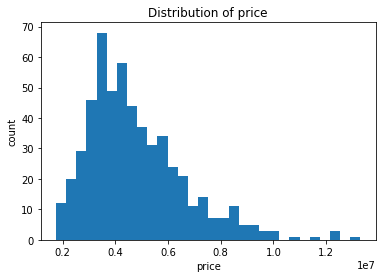

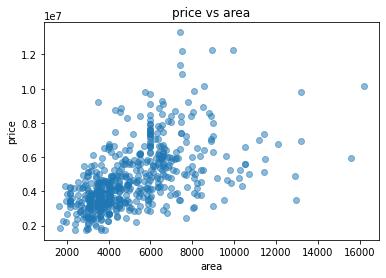

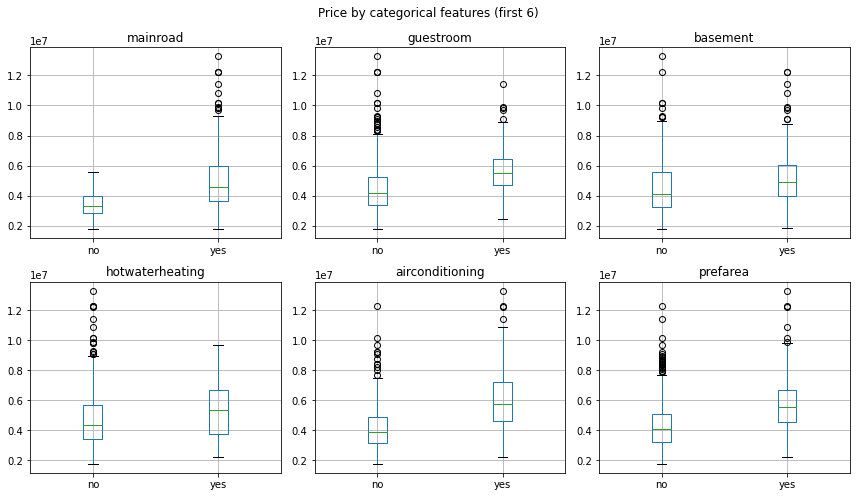

In [5]:
# Target distribution
plt.figure(figsize=(6,4))
plt.hist(df["price"], bins=30)
plt.title("Distribution of price")
plt.xlabel("price")
plt.ylabel("count")
plt.show()

# Price vs area
plt.figure(figsize=(6,4))
plt.scatter(df["area"], df["price"], alpha=0.5)
plt.title("price vs area")
plt.xlabel("area")
plt.ylabel("price")
plt.show()

# A quick look at categorical effects (boxplots)
cat_cols = df.select_dtypes(include="object").columns.tolist()
if cat_cols:
    n = min(6, len(cat_cols))
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes = axes.ravel()
    for i, col in enumerate(cat_cols[:n]):
        # simple boxplot without seaborn
        df.boxplot(column="price", by=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel("")
    plt.suptitle("Price by categorical features (first 6)")
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns detected.")


## 4) Split + Preprocess (without leakage)

We'll build a **Pipeline**:
- numeric: `StandardScaler()`
- categorical: `OneHotEncoder(handle_unknown="ignore")`

Why a pipeline?
- prevents *data leakage* (scaler/encoder fit only on train during `.fit()`)
- makes cross-validation safe and easy



## Why use a preprocessing Pipeline?
We use `Pipeline` and `ColumnTransformer` to:
- Avoid data leakage
- Keep preprocessing reproducible
- Apply transformations consistently to train/test data


In [6]:
# Define X/y
TARGET = "price"
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Identify feature types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (436, 12)  Test size: (109, 12)


## 5) Baseline: Linear Regression

We'll fit a standard least-squares linear regression and evaluate with:

- **RMSE** (in target units)
- **R²** (fraction of variance explained)

**Checkpoint (ask students):**
- What does RMSE mean in real-world terms here?
- Why can R² look good even when the model is wrong for the task?


In [7]:
lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("Linear Regression")
print("Train RMSE:", rmse(y_train, y_train_pred))
print("Test  RMSE:", rmse(y_test, y_test_pred))
print("Train R^2:", float(r2_score(y_train, y_train_pred)))
print("Test  R^2:", float(r2_score(y_test, y_test_pred)))


Linear Regression
Train RMSE: 984051.9236507412
Test  RMSE: 1324506.9600914395
Train R^2: 0.6859438988560158
Test  R^2: 0.6529242642153179


## 6) Diagnostics: residuals and predictions

A model can have decent metrics and still be systematically wrong.  
Two quick plots:

- **Actual vs Predicted** (should cluster around the diagonal)
- **Residuals vs Predicted** (look for patterns; ideally centered around 0)

**Checkpoint (ask students):**
- Do residuals fan out as predictions increase? (heteroscedasticity)
- Are there obvious outliers?


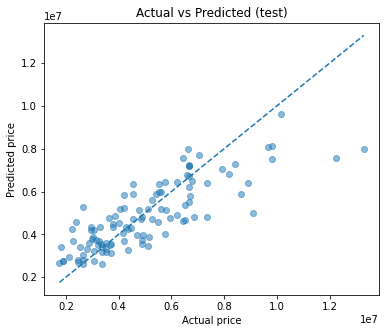

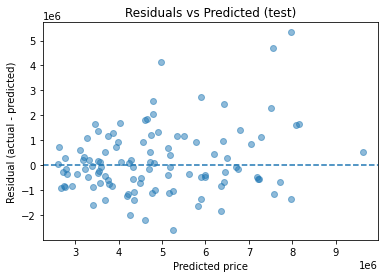

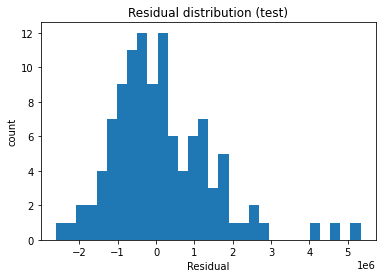

In [8]:
# Actual vs predicted
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
minv, maxv = float(y_test.min()), float(y_test.max())
plt.plot([minv, maxv], [minv, maxv], linestyle="--")
plt.title("Actual vs Predicted (test)")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.show()

# Residuals vs predicted
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted (test)")
plt.xlabel("Predicted price")
plt.ylabel("Residual (actual - predicted)")
plt.show()

# Residual distribution
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Residual distribution (test)")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()


## 7) Interpreting coefficients (with caution)

For one-hot encoded variables, each coefficient is relative to the dropped reference level (`drop="first"`).

We'll extract coefficients from the trained pipeline.

> Note: With many correlated features, coefficients can be unstable (multicollinearity). Regularization helps.


In [9]:
# Get feature names after preprocessing
ohe = lr_model.named_steps["preprocess"].named_transformers_["cat"]
num_names = list(numeric_features)

if len(categorical_features) > 0:
    cat_names = list(ohe.get_feature_names_out(categorical_features))
else:
    cat_names = []

feature_names = num_names + cat_names

coefs = lr_model.named_steps["model"].coef_

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
display(coef_df.sort_values("abs_coef", ascending=False).head(15))

print("Intercept:", float(lr_model.named_steps["model"].intercept_))


,feature,coef,abs_coef
9,airconditioning_yes,791426.735843,791426.735843
8,hotwaterheating_yes,684649.885339,684649.885339
10,prefarea_yes,629890.565313,629890.565313
2,bathrooms,521879.027748,521879.027748
0,area,519552.416340,519552.416340
12,furnishingstatus_unfurnished,-413645.062228,413645.062228
7,basement_yes,390251.176181,390251.176181
5,mainroad_yes,367919.947680,367919.947680
3,stories,349251.438906,349251.438906
6,guestroom_yes,231610.037176,231610.037176


Intercept: 3969403.5565888807



## Interpreting Linear Regression
Key questions students should answer:
- Which variables increase predictions?
- Which decrease them?
- Are effects large or small?
- Are signs intuitive?


## 8) OLS statistical summary (optional but useful in class)

`statsmodels` can show:
- p-values
- confidence intervals
- overall F-statistic

⚠️ Caveat: p-values assume certain conditions (e.g., residual normality, correct specification). Use as a guide, not gospel.


In [10]:
# Build the design matrix that matches the pipeline preprocessing
X_train_design = lr_model.named_steps["preprocess"].fit_transform(X_train)

# statsmodels wants a dense array
X_train_dense = X_train_design.toarray() if hasattr(X_train_design, "toarray") else X_train_design

X_train_sm = sm.add_constant(X_train_dense)
ols = sm.OLS(y_train.values, X_train_sm).fit()

print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     70.90
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           2.16e-97
Time:                        15:35:18   Log-Likelihood:                -6635.2
No. Observations:                 436   AIC:                         1.330e+04
Df Residuals:                     422   BIC:                         1.336e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.969e+06   1.75e+05     22.699      0.0

## 9) Regularization: Ridge vs Lasso

Regularization is especially helpful when:
- many correlated features (multicollinearity)
- noisy features
- you want more stable coefficients

We'll compare:
- **Ridge (L2):** shrinks coefficients smoothly, rarely to exactly 0  
- **Lasso (L1):** can shrink some coefficients to exactly 0 (feature selection)

We'll use a simple loop over a few `alpha` values.


In [11]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

def eval_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    return {
        "train_rmse": rmse(y_train, pred_train),
        "test_rmse": rmse(y_test, pred_test),
        "train_r2": float(r2_score(y_train, pred_train)),
        "test_r2": float(r2_score(y_test, pred_test)),
    }

results = []

for a in alphas:
    ridge_model = Pipeline(steps=[("preprocess", preprocess), ("model", Ridge(alpha=a, random_state=RANDOM_STATE))])
    lasso_model = Pipeline(steps=[("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=10000, random_state=RANDOM_STATE))])

    r = eval_model(ridge_model, X_train, y_train, X_test, y_test)
    r.update({"model":"Ridge", "alpha":a})
    results.append(r)

    r = eval_model(lasso_model, X_train, y_train, X_test, y_test)
    r.update({"model":"Lasso", "alpha":a})
    results.append(r)

results_df = pd.DataFrame(results).sort_values(["model","alpha"])
display(results_df)


,train_rmse,test_rmse,train_r2,test_r2,model,alpha
1,9.840519e+05,1.324507e+06,0.685944,0.652924,Lasso,0.01
3,9.840519e+05,1.324507e+06,0.685944,0.652924,Lasso,0.10
5,9.840519e+05,1.324508e+06,0.685944,0.652924,Lasso,1.00
7,9.840519e+05,1.324519e+06,0.685944,0.652918,Lasso,10.00
9,9.840522e+05,1.324624e+06,0.685944,0.652863,Lasso,100.00
0,9.840519e+05,1.324523e+06,0.685944,0.652916,Ridge,0.01
2,9.840524e+05,1.324668e+06,0.685944,0.652840,Ridge,0.10
4,9.840978e+05,1.326096e+06,0.685915,0.652091,Ridge,1.00
6,9.868066e+05,1.338647e+06,0.684183,0.645474,Ridge,10.00
8,1.036396e+06,1.424534e+06,0.651645,0.598522,Ridge,100.00


## 10) (Optional) Cross-validation for a more reliable estimate

A single train/test split can be lucky or unlucky.  
Cross-validation gives a steadier estimate of generalization error.

We'll compute 5-fold CV RMSE for the baseline model.


In [12]:
# Note: scoring returns *negative* RMSE, so we multiply by -1
neg_rmse_scores = cross_val_score(
    lr_model,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

rmse_scores = -neg_rmse_scores
print("CV RMSE scores:", rmse_scores)
print("Mean CV RMSE:", float(rmse_scores.mean()))
print("Std  CV RMSE:", float(rmse_scores.std()))


CV RMSE scores: [2618934.16413141  975775.55205881  934727.802344    932192.51987419
 1024003.07902875]
Mean CV RMSE: 1297126.623487433
Std  CV RMSE: 661747.3780371804


## 11) (Optional) Gradient descent implementation

This section is for *conceptual reinforcement*.

- We'll re-use the **same preprocessed design matrix** from the pipeline.
- Then implement gradient descent on standardized features.

**Checkpoint (ask students):**
- What happens if the learning rate is too high? too low?
- How do we know we've converged?



## Model Diagnostics — Critical Thinking
A regression model is *not finished* after fitting.

We must check:
- Residual distribution → should be roughly normal
- Patterns in residuals → should look random
- Prediction vs actual alignment

If assumptions fail → model may be unreliable.


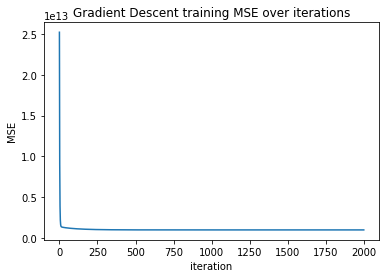

Gradient Descent Test RMSE: 1324487.8073046755
Gradient Descent Test R^2: 0.6529343017911051


In [13]:
# Use the already-fit preprocessing from the linear regression pipeline
# (Refit to keep this cell independent if students run it out of order)
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray() if hasattr(X_test_gd, "toarray") else X_test_gd

# Add intercept column
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]), X_test_gd]

def gradient_descent(X, y, lr=0.05, n_iter=2000):
    theta = np.zeros(X.shape[1])
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta
        grad = (2/m) * (X.T @ (y_pred - y))
        theta -= lr * grad
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)

theta_gd, mse_hist = gradient_descent(X_train_gd, y_train.values, lr=0.05, n_iter=2000)

plt.figure(figsize=(6,4))
plt.plot(mse_hist)
plt.title("Gradient Descent training MSE over iterations")
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.show()

y_test_pred_gd = X_test_gd @ theta_gd
print("Gradient Descent Test RMSE:", rmse(y_test, y_test_pred_gd))
print("Gradient Descent Test R^2:", float(r2_score(y_test, y_test_pred_gd)))


## 12) Wrap-up

Key takeaways:
- Use pipelines to avoid leakage and make evaluation consistent
- Always look at **residuals** and **actual vs predicted**
- Regularization helps when features are correlated or you have many dummies
- Metrics are not the whole story — diagnostics matter

### Mini-exercises (assign to students)
1. Try `np.log(price)` as the target. Does it improve residuals?
2. Add polynomial features for `area` (e.g., area²) and compare performance.
3. Use a validation set (train/val/test) and tune `alpha` for Ridge/Lasso.
4. Identify the largest residuals (worst predictions). What do those rows have in common?



## Why Regularization?
Real datasets often have:
- Multicollinearity
- Noise
- Too many predictors

Ridge and Lasso:
- Reduce overfitting
- Stabilize coefficients
- Improve generalization



## Gradient Descent (Conceptual)
This section shows *how* models learn:
- Start with random coefficients
- Iteratively reduce error
- Move toward optimal solution

Focus on the idea — not the math details.
